In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam

In [48]:
class Net(nn.Module):
    """maps from time to positive numbers"""

    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 12)
        self.lin2 = nn.Linear(12, 12)
        self.lin3 = nn.Linear(12, 12)
        self.lin4 = nn.Linear(12, 1)

        self.act = torch.relu

    def forward(self, t):
        x = self.lin1(t)
        x = self.act(x)
        x = self.lin2(x)
        x = self.act(x)
        x = self.lin3(x)
        x = self.act(x)
        x = self.lin4(x)

        return torch.sigmoid(x)

In [49]:
N = 50000.

S0 = N - 100.
I0 = 100.
D0 = 0.
R0 = 0.


St = [S0]
It = [I0]
Rt = [R0]
Dt = [D0]

dt = 1

beta_time_series = 0.11 + 0.02 * torch.sin(torch.arange(200) / 5)
alpha = 0.01
delta = 0.01
gamma_time_series = 0.1 / (1 - torch.exp(-(10 + torch.arange(200)) / 50))

for i in range(200 - 1):

    beta = beta_time_series[i]
    gamma = gamma_time_series[i]

    dS = (gamma * Rt[-1]) - (beta * St[-1] * It[-1] / N)
    dI = (beta * St[-1] * It[-1] / N) - (alpha + delta) * It[-1]
    dR = (alpha * It[-1]) - (gamma * Rt[-1])
    dD = delta * It[-1]

    S = St[-1] + (dt * dS)
    I = It[-1] + (dt * dI)
    R = Rt[-1] + (dt * dR)
    D = Dt[-1] + (dt * dD)

    St.append(S)
    It.append(I)
    Rt.append(R)
    Dt.append(D)

St = torch.tensor(St)
It = torch.tensor(It)
Rt = torch.tensor(Rt)
Dt = torch.tensor(Dt)

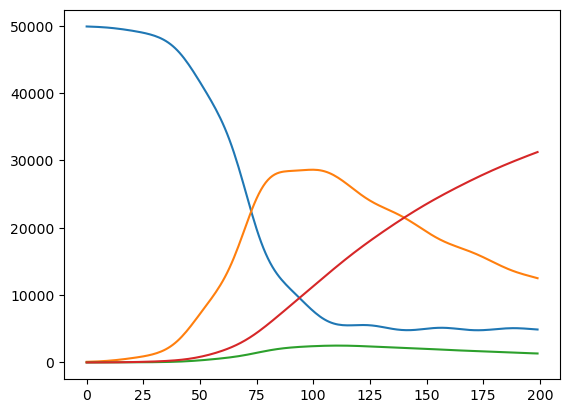

In [50]:
plt.plot(St)
plt.plot(It)
plt.plot(Rt)
plt.plot(Dt)

## instantiate greeks and reverse engineer the model

In [51]:
dI = (It[1:] - It[:-1]).reshape(-1, 1)
dD = (Dt[1:] - Dt[:-1]).reshape(-1, 1)

alpha = Net()
beta = Net()
gamma = Net()
delta = Net()

In [52]:
def second_derivative_loss(input_, model):

    input_.requires_grad = True
    ft = model(input_)
    
    dftdt = torch.autograd.grad(ft.sum(), input_, create_graph=True)[0]
    df2tdt2 = torch.autograd.grad(dftdt.sum(), input_, create_graph=True)[0]

    return torch.mean(df2tdt2**2)

In [ ]:
optim_alpha = Adam(alpha.parameters(), lr = 1e-4)
optim_beta = Adam(beta.parameters(), lr = 1e-4)
optim_gamma = Adam(gamma.parameters(), lr = 1e-4)
optim_delta = Adam(delta.parameters(), lr = 1e-4)

S0 = N - It[0]
I0 = It[0]
R0 = 0
D0 = 0

S_train = torch.tensor([N - It[0] for _ in range(199)]).reshape(-1, 1)
I_train = torch.tensor([It[0] for _ in range(199)]).reshape(-1, 1)
R_train = torch.tensor([0. for _ in range(199)]).reshape(-1, 1)
D_train = torch.tensor([0. for _ in range(199)]).reshape(-1, 1)

EPOCHS = 200_001
T = torch.arange(199).reshape(199, 1) * 1.

for i in range(EPOCHS):

    optim_alpha.zero_grad()
    optim_beta.zero_grad()
    optim_gamma.zero_grad()
    optim_delta.zero_grad()
    
    ### I and D should be close to their true values
    dD_train = delta(T) * I_train
    loss_dD = torch.mean((dD_train - dD)**2)

    dI_train = (beta(T) * I_train * S_train / N) - (alpha(T) + gamma(T)) * I_train
    loss_dI = torch.mean((dI_train - dI)**2)
    
    ### parameters should be smooth
    loss_smooth_alpha = second_derivative_loss(T, alpha)
    loss_smooth_beta = second_derivative_loss(T, beta)
    loss_smooth_gamma = second_derivative_loss(T, gamma)
    loss_smooth_delta = second_derivative_loss(T, delta)
  
    ### update model parameters
    loss_dI.backward()
    loss_dD.backward()

    loss_smooth_alpha.backward()
    loss_smooth_beta.backward()
    loss_smooth_gamma.backward()
    loss_smooth_delta.backward()

    optim_alpha.step()
    optim_beta.step()
    optim_gamma.step()
    optim_delta.step()
    
    ### update S I R D
    I_train = I0 + dI_train.detach()
    D_train = D0 + dD_train.detach()

    # update R and S
    dS_train = (gamma(T) * R_train) - (beta(T) * I_train * S_train / N)
    S_train = S0 + dS_train.detach()

    dR_train = (alpha(T) * I_train) - (gamma(T) * R_train)
    R_train = R0 + dR_train.detach()

    if i % 100 == 0:
        print('=== Epoch', i, '| Loss dD:', loss_dD.item(), '===')
    


=== Epoch 0 | Loss dD: 12873.9970703125 ===
=== Epoch 100 | Loss dD: 10810.11328125 ===
=== Epoch 200 | Loss dD: 11475.98828125 ===
=== Epoch 300 | Loss dD: 10906.9775390625 ===
=== Epoch 400 | Loss dD: 11250.474609375 ===
=== Epoch 500 | Loss dD: 13340.4169921875 ===
=== Epoch 600 | Loss dD: 13556.8857421875 ===
=== Epoch 700 | Loss dD: 13327.826171875 ===
=== Epoch 800 | Loss dD: 13432.19140625 ===
=== Epoch 900 | Loss dD: 12228.69140625 ===
=== Epoch 1000 | Loss dD: 13578.9775390625 ===
=== Epoch 1100 | Loss dD: 12049.958984375 ===
=== Epoch 1200 | Loss dD: 12333.583984375 ===
=== Epoch 1300 | Loss dD: 12110.3720703125 ===
=== Epoch 1400 | Loss dD: 14401.09375 ===
=== Epoch 1500 | Loss dD: 14418.9970703125 ===
=== Epoch 1600 | Loss dD: 12466.236328125 ===
=== Epoch 1700 | Loss dD: 15104.771484375 ===


In [ ]:
plt.plot(Dt)
plt.plot(D_train.detach())

In [ ]:
plt.plot(beta_time_series)
plt.plot(beta(T).detach())